In [1]:
import os, random, copy, json, requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import patches, text
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from itertools import chain

import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

device: cpu


# Load the Flickr8k dataset

## Option 1: Return Image with All Associated Captions

In this approach, for each index, __getitem__ returns the same image with all five captions. This means that during training, each image will be processed once per batch but will be associated with all its captions.

**Benefits:**

- This approach keeps all the context (captions) for an image together, which can be useful if the model or training strategy benefits from seeing all the descriptions of an image at once.
- It's efficient in terms of I/O since to load each image once per batch.

**Considerations:**

- The model and training loop need to handle batches where each item contains one image and multiple captions.
- This might require modifications in the way to compute the loss, as i'll be dealing with a batch of images and a batch of caption sets.

## Option 2: Return Image with One Caption at a Time

In this approach, __getitem__ randomly selects one of the captions to return with the image. Alternatively, I could cycle through the captions in a deterministic way.

**Benefits:**

- This method simplifies the training loop and loss calculation since each item in a batch is a standard image-caption pair.
- It aligns with standard practices for image-caption pair datasets.

**Considerations:**

- Each image will be loaded multiple times (once for each caption), which may be less efficient in terms of I/O.
- The model sees each caption independently and doesn't have the context of the other captions for the same image.


In [2]:
MAX_SEQ_LENGTH=20  # In reality the max length is 38

class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        # Add special tokens
        for token in ['<PAD>', '<SOS>', '<EOS>', '<UNK>']:
            self.add_word(token)
    
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions_list):
        for captions in captions_list:
            for caption in captions:
                words = nltk.word_tokenize(caption.lower())
                for word in words:
                    self.add_word(WordNetLemmatizer().lemmatize(word))

    def lemma_to_tokens(self, lemma):
        tokens = nltk.word_tokenize(lemma.lower())
        token_ids = [self.word2idx['<SOS>']]  # Start with <SOS> token

        # Truncate the tokens to fit within the MAX_SEQ_LENGTH with <EOS>
        for token in tokens[:MAX_SEQ_LENGTH - 2]:  # Reserve space for <SOS> and <EOS>
            if token == '.':  # Stop if we see a period
                break
            elif token in self.word2idx:
                token_ids.append(self.word2idx[token])
            else:
                token_ids.append(self.word2idx['<UNK>'])  # Replace unknown words with <UNK>

        token_ids.append(self.word2idx['<EOS>'])  # End with <EOS> token

        # Pad the sequence to a fixed length
        return token_ids + [self.word2idx['<PAD>']] * (MAX_SEQ_LENGTH - len(token_ids))

    def tokens_to_lemma(self, tokens):
        words = []
        for token in tokens:
            word = self.idx2word[token]
            words.append(word)
        return ' '.join(words)
    
    

# Create a vocabulary object
vocab = Vocabulary()


class Flickr8kDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, split='train', transform=None):
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.split = split
        self.transform = transform
        self.image_paths = self.load_image_paths()
        self.annotations = self.load_annotations()

    def load_image_paths(self):
        image_paths = []
        with open(f'{self.annotation_folder}/Flickr_8k.{self.split}Images.txt', 'r') as f:
            lines = f.readlines()
            for l in lines:
              image_paths.append(l.strip())
        return image_paths

    def load_annotations(self):
        annotations = defaultdict(list)
        with open(f'{self.annotation_folder}/Flickr8k.token.txt', 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split('\t')
                image_name, caption = parts[0].split('#')[0], parts[1]
                annotations[image_name].append(caption)
        return annotations

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_name = self.image_paths[idx]
        image_path = f'{self.image_folder}/{image_name}'
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        # Get captions for the current image
        captions = self.annotations[image_name]

        # select a random caption from the 5 captions for the current image
        caption = captions[random.randint(0, 4)]

        # Preprocess caption
        tokenized_caption = torch.tensor(vocab.lemma_to_tokens(caption))

        # select a random caption from the 5 captions for the current image
        return {'image': image, 'caption': tokenized_caption}
    

In [3]:
image_folder = 'Flickr8k_Dataset'
annotation_folder = 'Flickr8k_text'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = Flickr8kDataset(image_folder, annotation_folder, split='train', transform=transform)
validation_dataset = Flickr8kDataset(image_folder, annotation_folder, split='dev', transform=transform)
test_dataset = Flickr8kDataset(image_folder, annotation_folder, split='test', transform=transform)

# CAN ADD THE TEST TO THE VALIDATION OR TRAINIING IN ORDER TO HAVE MORE DATA
#validation_dataset = validation_dataset + test_dataset

print(f"Train: {len(train_dataset)} imgs; Val: {len(validation_dataset)} imgs; Test: {len(test_dataset)} imgs")


Train: 6000 imgs; Val: 1000 imgs; Test: 1000 imgs


# Lemmatization & Vocabulary

In [4]:
# Download the WordNet resource for lemmatization
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/psaghelyi-
[nltk_data]     remote/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/psaghelyi-
[nltk_data]     remote/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:


# Build the vocabulary from the captions in the training dataset
vocab.build_vocabulary(train_dataset.annotations.values())

VOCAB_SIZE = len(vocab.word2idx)

# Print the size of the vocabulary
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 7705


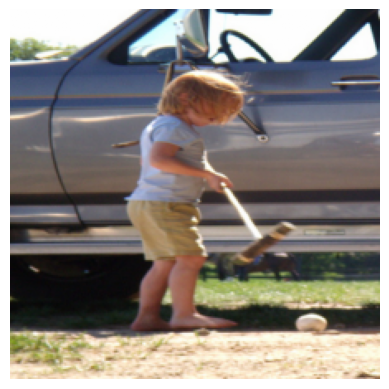

Image path: 2903617548_d3e38d7f88.jpg
- tensor([   1,    4,   24,   19,    3, 4282,   88,   27,    4,  895,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
- <SOS> a little girl <UNK> croquet next to a truck <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [6]:
def visualize_sample(dataset, i=0):
  sample = dataset[i]
  image, caption = sample['image'], sample['caption']

  # Convert PyTorch tensor to NumPy array and transpose the dimensions
  image_np = np.transpose(image.numpy(), (1, 2, 0))

  plt.imshow(image_np)
  plt.axis('off')
  plt.show()

  lemma = vocab.tokens_to_lemma(caption.tolist())
  print(f"Image path: {dataset.image_paths[i]}")
  print(f"- {caption}")
  print(f"- {lemma}")

visualize_sample(train_dataset, 1)

**Define the DataSet Loaders**

In [7]:
BATCH_SIZE = 64

#def custom_collate_fn(data):
#    images, captions_list = zip(*data)
#    images = torch.stack(images, 0)

#    # Flatten and pad captions
#    captions = [torch.tensor(caption) for captions in captions_list for caption in captions]
#    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.word2idx['<PAD>'])

#    return images, captions


# use this for the multi-caption option
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

**Encoder and Decoder Model Definition**:
   - Define CNN encoder (possibly using a pre-trained model like ResNet) and sequence-based decoder (RNN, LSTM, or Transformer).
   - Implement an attention mechanism in the decoder if desired.

In [8]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Load a pre-trained ResNet model
        resnet = models.resnet50(weights='DEFAULT')
        # Remove the last fully connected layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # Pass the image through the ResNet, excluding the last FC layer
        features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.embed(features))
        return features


class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        # lstm_output shape: [batch_size, seq_len, hidden_size]
        attention_scores = self.attention(lstm_output).squeeze(2)  # [batch_size, seq_len]
        attention_weights = F.softmax(attention_scores, dim=1).unsqueeze(2)  # [batch_size, seq_len, 1]
        weighted_output = lstm_output * attention_weights  # [batch_size, seq_len, hidden_size]
        return weighted_output.sum(dim=1)  # [batch_size, hidden_size]
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, vocab_size)
        self.attention = SelfAttention(hidden_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)

        #print(f"Caption tensor shape: {captions.shape}")  # Expected: [BATCH_SIZE, MAX_SEQ_LENGTH]
        #print(f"Embeddings shape (after embed layer): {embeddings.shape}")  # Expected: [BATCH_SIZE, MAX_SEQ_LENGTH, 256]

        embeddings = embeddings.view(-1, MAX_SEQ_LENGTH, embeddings.size(-1))

        # Expand features to match the sequence length of embeddings
        features_expanded = features.unsqueeze(1).expand(-1, MAX_SEQ_LENGTH, -1)

        # Debug prints to check the shapes (can be removed later)
        #print(f"Features expanded shape: {features_expanded.shape}")  # Expected: [BATCH_SIZE, MAX_SEQ_LENGTH, embed_size]
        #print(f"Embeddings shape: {embeddings.shape}")                # Expected: [BATCH_SIZE, MAX_SEQ_LENGTH, embed_size]
        
        if torch.isnan(embeddings).any():
            print("Embeddings has NaN")
        if torch.isnan(features_expanded).any():
            print("Features expanded has NaN")

        # Concatenate along the last dimension (embedding dimension)
        combined = torch.cat((features_expanded, embeddings), 2)
        if torch.isnan(combined).any():
            print("Combined has NaN")
        #print("Max value in combined:", combined.max())
        #print("Min value in combined:", combined.min())
                
        #lstm_params_before = sum(p.sum() for p in self.lstm.parameters())
        lstm_output, (hidden_state, cell_state) = self.lstm(embeddings)  # lstm_output: [batch_size, seq_len, hidden_size]
        #lstm_params_after = sum(p.sum() for p in self.lstm.parameters())
        #print("LSTM params sum before:", lstm_params_before)
        #print("LSTM params sum after:", lstm_params_after)
        
        # Apply self-attention on LSTM output
        attention_output = self.attention(lstm_output)  # attention_output: [batch_size, hidden_size]
        attention_output = attention_output.unsqueeze(1)  # Add seq_len dimension: [batch_size, 1, hidden_size]
        #print("Attention output shape:", attention_output.shape)

        combined_output = torch.cat((attention_output.expand_as(lstm_output), lstm_output), 2)  # [batch_size, seq_len, hidden_size * 2]
        #print("Combined output shape:", combined_output.shape)
        
        #print("Hidden state max:", hidden_state.max())
        #print("Cell state max:", cell_state.max())
        if torch.isnan(combined_output).any():
            print("combined_output has NaN")

        outputs = self.linear(combined_output)
        return outputs

    def sample(self, features, max_len=MAX_SEQ_LENGTH):
        self.eval()  # Ensure the model is in eval mode
        generated_caption = []
        states = None
        inputs = features.unsqueeze(1)  # Shape: [1, 1, 256]

        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)  # hiddens: [1, 1, hidden_size]
            attention_output = self.attention(hiddens)  # attention_output: [1, hidden_size]
            attention_output = attention_output.unsqueeze(1)  # [1, 1, hidden_size]
            combined_output = torch.cat((attention_output, hiddens), 2)  # [1, 1, hidden_size * 2]
            
            outputs = self.linear(combined_output.squeeze(1))  # Now shape matches [1, hidden_size * 2]
            predicted = outputs.argmax(1)
            if predicted.item() == vocab.word2idx['<EOS>']:
                break
            generated_caption.append(predicted.item())
            inputs = self.embed(predicted).unsqueeze(1)

        return generated_caption
    
    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                torch.nn.init.zeros_(param)



- `lr=0.005`: This is the learning rate. It controls how much the parameters are adjusted during each optimization step. A smaller learning rate means the model will learn slower, but it can help the model reach better minima.

- `momentum=0.9`: This adds a fraction of the previous update to the current update. It is a method to accelerate the optimizer in the right direction and dampen oscillations.

- `weight_decay=0.0005`: This adds L2 penalty for large weights in the model (also known as regularization). It helps prevent overfitting by penalizing large weights.

In [9]:
embed_size = 256
hidden_size = 512
vocab_size = VOCAB_SIZE

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)
decoder._init_weights()

# to ensure padding tokens don't contribute to loss.
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>'])
optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=0.00005)
# Gradually decrease the learning rate 0.005, momentum=0.9, weight_decay=0.0005 
#optimizer = torch.optim.SGD(chain(encoder.parameters(), decoder.parameters()), lr=0.00005, momentum=0.9, weight_decay=0.0005)


**Training Loop**
  - Loss Function: Cross-Entropy Loss.
  - Optimizer: Let's do Adam (I have a slow machine and I found Adam to be faster than SGD)

In [10]:
def train(encoder, decoder, train_loader, optimizer, criterion, current_epoch):
    encoder.train()
    decoder.train()

    total_loss = 0

    # Wrap train_loader with tqdm for a progress bar
    progress_bar = tqdm(train_loader, desc=f'Epoch {current_epoch+1}')

    for data in progress_bar:
    #for data in train_loader:
        images = data['image'].to(device) # [BATCH_SIZE, 3, 224, 224]
        captions = data['caption'].to(device) # [BATCH_SIZE, MAX_SEQ_LENGTH]

        #print (f"Images shape: {images.shape}")
        #print (f"Captions shape: {captions.shape}")
        
        # Forward pass
        features = encoder(images)
        #print (f"Features shape: {features.shape}")
        outputs = decoder(features, captions)

        # Calculate loss
        loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))
        total_loss += loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients to avoid exploding gradients
        # see: https://jamesmccaffrey.wordpress.com/2022/10/17/the-difference-between-pytorch-clip_grad_value_-and-clip_grad_norm_-functions/
        torch.nn.utils.clip_grad_value_(chain(encoder.parameters(), decoder.parameters()), clip_value=1.5)
        #torch.nn.utils.clip_grad_norm_(chain(encoder.parameters(), decoder.parameters()), max_norm=0.5, norm_type=2)

        optimizer.step()

        # Update the progress bar description with the current loss
        progress_bar.set_postfix(loss=loss.item())
        if torch.isnan(loss).any():
            break


    # Calculate average loss over the epoch
    average_loss = total_loss / len(train_loader)
    print(f'Epoch [{current_epoch + 1}] completed, Average Loss: {average_loss:.4f}')



    # At the end of each epoch, select a random image and its corresponding ground truth caption    
    encoder.eval()
    decoder.eval()

    random_idx = random.randint(0, images.size(0) - 1)
    sample_image = images[random_idx]
    correct_caption = captions[random_idx]  # Tensor of token IDs for the correct caption
    correct_caption_words = [vocab.idx2word[token.item()] for token in correct_caption if token.item() in vocab.idx2word]

    with torch.no_grad():
        sample_features = encoder(sample_image.unsqueeze(0).to(device))
        sample_caption_indices = decoder.sample(sample_features)
        sample_generated_caption = ' '.join([vocab.idx2word[idx] for idx in sample_caption_indices])

    print(f"Epoch {current_epoch + 1} Sample:")
    print(f"Correct caption: {' '.join(correct_caption_words)}")
    print(f"Generated caption: {sample_generated_caption}")


In [11]:
def validate(encoder, decoder, val_loader, criterion):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        total_loss = 0
        for data in val_loader:
            images = data['image'].to(device)
            captions = data['caption'].to(device)

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions)

            # Calculate loss
            loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))
            total_loss += loss.item()

        average_loss = total_loss / len(val_loader)
        print(f'Validation Loss: {average_loss:.4f}')
        return average_loss


**Early stopping**
  - Early Stopping: To avoid overfitting, I'll use early stopping. I'll save the model with the lowest validation loss and stop training if the validation loss doesn't improve after a set number of epochs.

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                                Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [13]:
num_epochs = 20  
best_val_loss = float('inf')  # Initialize best validation loss as infinity
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Train and Validate
    train(encoder, decoder, train_loader, optimizer, criterion, epoch)
    val_loss = validate(encoder, decoder, validation_loader, criterion)
    early_stopping(val_loss)
    scheduler.step(val_loss)
    
    # Checkpointing
    if val_loss < best_val_loss:
        print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(encoder.state_dict(), f'encoder_best_{epoch+1}.pth')
        torch.save(decoder.state_dict(), f'decoder_best_{epoch+1}.pth')
        best_val_loss = val_loss

    # Check if val_loss is NaN
    if val_loss == float('NaN'):
        print(f"Stopping training as validation loss became NaN at Epoch {epoch + 1}")
        break
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


Epoch 1/20
----------


Epoch 1:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 94/94 [07:32<00:00,  4.82s/it, loss=4.63]


Epoch [1] completed, Average Loss: 7.3072
Epoch 1 Sample:
Correct caption: <SOS> the brown dog is being chased by a black dog while holding a small toy in his mouth <EOS>
Generated caption: same a a a a a a a a a a a a a a a a a a a
Validation Loss: 4.7021
Validation loss decreased (inf --> 4.702057). Saving model...
Epoch 2/20
----------


Epoch 2: 100%|██████████| 94/94 [07:28<00:00,  4.77s/it, loss=3.74]


Epoch [2] completed, Average Loss: 4.1507
Epoch 2 Sample:
Correct caption: <SOS> a person is jumping a ramp on a snowboard <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: venture man man man man man man man man man man man man man man man man <UNK> <UNK> <UNK>
Validation Loss: 3.7941
Validation loss decreased (4.702057 --> 3.794111). Saving model...
Epoch 3/20
----------


Epoch 3: 100%|██████████| 94/94 [07:19<00:00,  4.68s/it, loss=3.03]


Epoch [3] completed, Average Loss: 3.4460
Epoch 3 Sample:
Correct caption: <SOS> a large , black dog is chasing two <UNK> in a field <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: taken his his his his his his his his his his his his his his his his his his his
Validation Loss: 3.2219
Validation loss decreased (3.794111 --> 3.221899). Saving model...
Epoch 4/20
----------


Epoch 4: 100%|██████████| 94/94 [07:04<00:00,  4.52s/it, loss=2.59]


Epoch [4] completed, Average Loss: 2.8832
Epoch 4 Sample:
Correct caption: <SOS> the animal is near the pond <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: r.v woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman
Validation Loss: 2.6584
Validation loss decreased (3.221899 --> 2.658385). Saving model...
Epoch 5/20
----------


Epoch 5: 100%|██████████| 94/94 [07:14<00:00,  4.62s/it, loss=2.32]


Epoch [5] completed, Average Loss: 2.4445
Epoch 5 Sample:
Correct caption: <SOS> a man wearing a helmet is on a bicycle in the air while people in the background watch <EOS>
Generated caption: <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS>
Validation Loss: 2.2924
Validation loss decreased (2.658385 --> 2.292431). Saving model...
Epoch 6/20
----------


Epoch 6: 100%|██████████| 94/94 [07:12<00:00,  4.60s/it, loss=2]   


Epoch [6] completed, Average Loss: 2.1030
Epoch 6 Sample:
Correct caption: <SOS> the white duck is swimming with a black dog <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: young young young young young young young young young young young young young young young young young young young young
Validation Loss: 2.0099
Validation loss decreased (2.292431 --> 2.009922). Saving model...
Epoch 7/20
----------


Epoch 7: 100%|██████████| 94/94 [07:09<00:00,  4.57s/it, loss=1.6] 


Epoch [7] completed, Average Loss: 1.8449
Epoch 7 Sample:
Correct caption: <SOS> three <UNK> in blue <UNK> swinging on a swing set <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: 
Validation Loss: 1.7740
Validation loss decreased (2.009922 --> 1.774024). Saving model...
Epoch 8/20
----------


Epoch 8: 100%|██████████| 94/94 [07:09<00:00,  4.57s/it, loss=1.54]


Epoch [8] completed, Average Loss: 1.6420
Epoch 8 Sample:
Correct caption: <SOS> a man in worn and ragged clothes <UNK> a satchel while passin a tree and trashcan <EOS> <PAD> <PAD>
Generated caption: retrieve at at at at at at at at at at at at at at at at at at at
Validation Loss: 1.6162
Validation loss decreased (1.774024 --> 1.616233). Saving model...
Epoch 9/20
----------


Epoch 9: 100%|██████████| 94/94 [07:19<00:00,  4.68s/it, loss=1.17]


Epoch [9] completed, Average Loss: 1.4559
Epoch 9 Sample:
Correct caption: <SOS> a large bird <UNK> in the water on the beach <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: an an an an an an an an an an an an an an an an an an an an
Validation Loss: 1.4282
Validation loss decreased (1.616233 --> 1.428157). Saving model...
Epoch 10/20
----------


Epoch 10: 100%|██████████| 94/94 [07:14<00:00,  4.62s/it, loss=1.29]


Epoch [10] completed, Average Loss: 1.3354
Epoch 10 Sample:
Correct caption: <SOS> a little boy on a green sled at night <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: black black black black black black black black black black black black black black black black black black black black
Validation Loss: 1.3381
Validation loss decreased (1.428157 --> 1.338118). Saving model...
Epoch 11/20
----------


Epoch 11: 100%|██████████| 94/94 [07:08<00:00,  4.56s/it, loss=1.13]


Epoch [11] completed, Average Loss: 1.2032
Epoch 11 Sample:
Correct caption: <SOS> a nicely dressed woman and bearded man in a small room <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: trumped with with with with with with with with with with with with with with with with with with with
Validation Loss: 1.1958
Validation loss decreased (1.338118 --> 1.195820). Saving model...
Epoch 12/20
----------


Epoch 12: 100%|██████████| 94/94 [07:10<00:00,  4.58s/it, loss=0.814]


Epoch [12] completed, Average Loss: 1.0998
Epoch 12 Sample:
Correct caption: <SOS> a boy is wearing a wetsuit on a crowded beach <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: and and and and and and and and and and and and and and and and and and and and
Validation Loss: 1.1055
Validation loss decreased (1.195820 --> 1.105480). Saving model...
Epoch 13/20
----------


Epoch 13: 100%|██████████| 94/94 [07:18<00:00,  4.67s/it, loss=1]    


Epoch [13] completed, Average Loss: 1.0194
Epoch 13 Sample:
Correct caption: <SOS> two <UNK> hugging on a bridge <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: across across across across across across across across across across across across across across across across across across across across
Validation Loss: 1.0230
Validation loss decreased (1.105480 --> 1.022994). Saving model...
Epoch 14/20
----------


Epoch 14: 100%|██████████| 94/94 [07:10<00:00,  4.58s/it, loss=0.789]


Epoch [14] completed, Average Loss: 0.9285
Epoch 14 Sample:
Correct caption: <SOS> brown dog leaping up with orange disc in mouth with blue and yellow toy boat in background <EOS> <PAD>
Generated caption: along along along along along along along along along along along along along along along along along along along along
Validation Loss: 0.9678
Validation loss decreased (1.022994 --> 0.967795). Saving model...
Epoch 15/20
----------


Epoch 15: 100%|██████████| 94/94 [07:10<00:00,  4.58s/it, loss=0.723]


Epoch [15] completed, Average Loss: 0.8666
Epoch 15 Sample:
Correct caption: <SOS> a girl playing in a puddle while wearing a pink coat <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS> <SOS>
Validation Loss: 0.8953
Validation loss decreased (0.967795 --> 0.895283). Saving model...
Epoch 16/20
----------


Epoch 16: 100%|██████████| 94/94 [07:10<00:00,  4.58s/it, loss=0.767]


Epoch [16] completed, Average Loss: 0.8061
Epoch 16 Sample:
Correct caption: <SOS> a white dog running on dirt <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: a a a a a a a a a a a a a a a a a a a a
Validation Loss: 0.8479
Validation loss decreased (0.895283 --> 0.847911). Saving model...
Epoch 17/20
----------


Epoch 17: 100%|██████████| 94/94 [07:20<00:00,  4.68s/it, loss=0.729]


Epoch [17] completed, Average Loss: 0.7513
Epoch 17 Sample:
Correct caption: <SOS> a man in black <UNK> a baby <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman
Validation Loss: 0.8025
Validation loss decreased (0.847911 --> 0.802525). Saving model...
Epoch 18/20
----------


Epoch 18: 100%|██████████| 94/94 [07:11<00:00,  4.59s/it, loss=0.663]


Epoch [18] completed, Average Loss: 0.7074
Epoch 18 Sample:
Correct caption: <SOS> a man <UNK> on a wood ramp while another <UNK> a fishing pole <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: in in in in in in in in in in in in in in in in in in in in
Validation Loss: 0.7479
Validation loss decreased (0.802525 --> 0.747897). Saving model...
Epoch 19/20
----------


Epoch 19: 100%|██████████| 94/94 [07:10<00:00,  4.58s/it, loss=0.565]


Epoch [19] completed, Average Loss: 0.6544
Epoch 19 Sample:
Correct caption: <SOS> two <UNK> are playing together on white carpet near a couch <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated caption: is is is is is is is is is is is is is is is is is is is is
Validation Loss: 0.7225
Validation loss decreased (0.747897 --> 0.722526). Saving model...
Epoch 20/20
----------


Epoch 20: 100%|██████████| 94/94 [07:12<00:00,  4.60s/it, loss=0.515]


Epoch [20] completed, Average Loss: 0.6159
Epoch 20 Sample:
Correct caption: <SOS> a girl dressed in a red and black top with black <UNK> is sitting on a wall <EOS> <PAD>
Generated caption: ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground
Validation Loss: 0.6935
Validation loss decreased (0.722526 --> 0.693497). Saving model...


# Test the trained model

In [14]:
encoder.load_state_dict(torch.load('encoder_best.pth'))
decoder.load_state_dict(torch.load('decoder_best.pth'))

encoder.to(device)
decoder.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'encoder_best.pth'

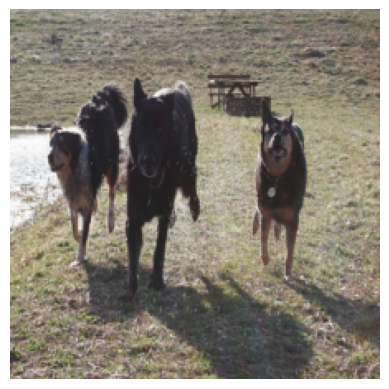

Image path: 3462454965_a481809cea.jpg
- Actual caption: [1, 337, 30, 3, 134, 49, 38, 278, 3, 134, 34, 119, 257, 67, 2, 0, 0, 0, 0, 0]
- Generated caption: <SOS> <SOS> <SOS> <SOS> <SOS> a <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
def test_model(dataset, i=1):
    encoder.eval()
    decoder.eval()

    sample = dataset[i]
    image, caption = sample['image'], sample['caption']

    # Convert PyTorch tensor to NumPy array and transpose the dimensions
    image_np = np.transpose(image.numpy(), (1, 2, 0))

    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

    # Process the image through the encoder and decoder to get the caption
    with torch.no_grad():
        features = encoder(image.unsqueeze(0).to(device))
        caption_indices = decoder.sample(features)
        generated_caption = ' '.join([vocab.idx2word[idx] for idx in caption_indices])

    print(f"Image path: {dataset.image_paths[i]}")
    print(f"- Actual caption: {caption}")
    print(f"- Generated caption: {generated_caption}")

test_model(test_dataset, 100)